# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley, 2016

# 1) Monty: The Python Siri

Let's make a Siri-like program with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [273]:
import wave
import pyaudio
import houndify
from houndify_keys import client_id, client_key
import json

In [274]:
def record_audio(fname, rec_sec=5):
    chunk = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000
    RECORD_SECONDS = rec_sec
    WAVE_OUTPUT_FILENAME = fname
    p = pyaudio.PyAudio()
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    all = []
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        data = stream.read(chunk)
        all.append(data)
    print("* done recording")
    stream.close()
    p.terminate()
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

In [241]:
record_audio('math.wav')

* done recording


In [291]:
clientId = client_id
clientKey = client_key
userId = "test_user"
requestInfo = {'ClientID': clientId,'UserID': userId}
client = houndify.StreamingHoundClient(clientId, clientKey, userId, requestInfo, sampleRate=16000)

class Listener(houndify.HoundListener):
    def onPartialTranscript(self, transcript):
        pass
    def onFinalResponse(self, response):
        respond(response)
    def onError(self, err):
        print('Error:', err)

def ask_houndify(fname):
    chunk = 1024
    l = Listener()
    client.start(l)
    f = wave.open(fname, 'rb')
    rate = f.getframerate()
    samples = f.readframes(chunk)
    finished = False
    while not finished:
        client.fill(samples)
        samples = f.readframes(chunk)
        if len(samples)==0:
            break
    client.finish()
    
def respond(response):
    data = json.loads(str(response))
    print(type(data))

In [292]:
ask_houndify('email.wav')
# ask_houndify('math.wav')
# ask_houndify('joke.wav')

In [261]:
email_json

# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/fall2016/ay250/resources -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [220]:
import aifc
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from detect_peaks import detect_peaks
%matplotlib inline

In [221]:
def read_aiff(path, chunk_size=1024, dtype=np.int32, byteswap=True):
    CHUNK = chunk_size
    f = aifc.open(path, 'rb')
    frame_rate = f.getframerate()
    nchannels = f.getnchannels()
    result = []
    data = f.readframes(CHUNK)
    while len(data) > 0:
        result.append(np.fromstring(data, dtype=np.int32).byteswap())
        data = f.readframes(CHUNK)
    result = np.concatenate(result)
    return result, frame_rate*nchannels

In [222]:
def find_peaks(data, frequency, plot=True):
    ft = np.fft.fft(d)
    N = len(d)*2
    T = 1.0 / 88200.
    x = np.linspace(0.0, N*T, N)
    y = data
    yf = fft(data)
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    yf = 2.0/N*np.abs(yf[(60<xf) & (xf<10000)])
    xf = xf[(60<xf) & (xf<10000)]
    ind = detect_peaks(yf, mph=5e6, mpd=1000)
    plt.figure(figsize=(12, 8))
    plt.plot(xf, yf)
    plt.plot(xf[ind], yf[ind], 'ro')
    return xf[ind], yf[ind]
    
#     plt.xlim(0, 1000)

(array([  261.5628707 ,   439.25062252,   522.50074051,  1318.06436801]),
 array([ 23239889.72057112,  34135220.71452497,  25161041.58126199,
         13606094.45560455]))

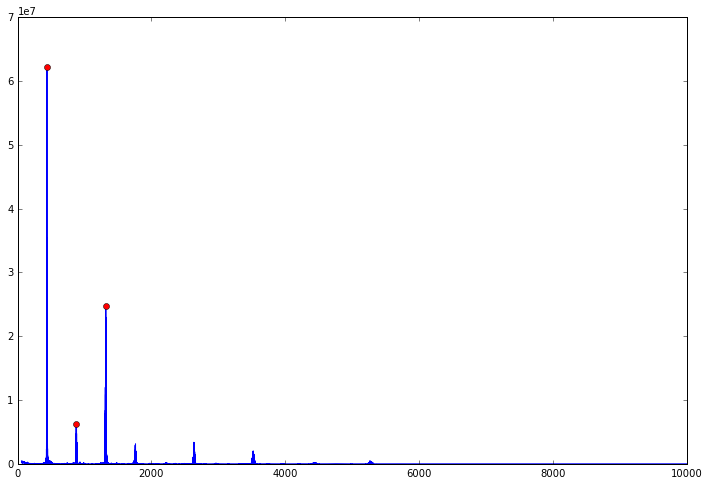

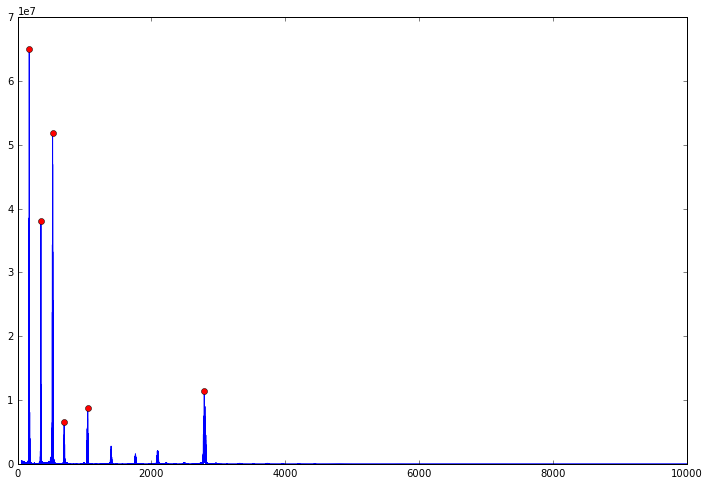

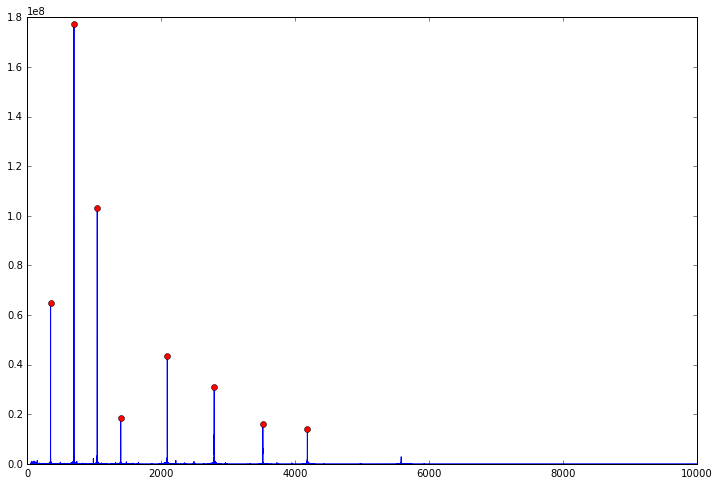

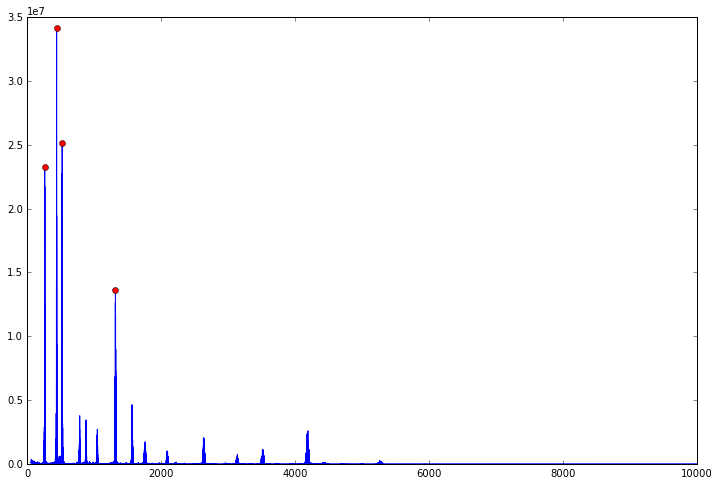

In [223]:
find_peaks(*read_aiff('./sound_files/A4_PopOrgan.aif'))
find_peaks(*read_aiff('./sound_files/F3_PopOrgan.aif'))
find_peaks(*read_aiff('./sound_files/F4_CathedralOrgan.aif'))
find_peaks(*read_aiff('./sound_files/C4+A4_PopOrgan.aif'))

In [224]:
a = 440
midi = [(a / 8) * (2 ** ((x - 9) / 12)) for x in range(127)]
notes = ['C',
         'C#/Db',
         'D',
         'D#/Eb',
         'E',
         'F',
         'F#/Gb',
         'G',
         'G#/Ab',
         'A',
         'A#/Bb',
         'B']
note_dict = {}
for i, m in enumerate(midi):
    octave = i//12+1
    note = notes[i%12]
    name = note+str(octave)
    note_dict[m] = name

In [225]:
def match_notes(peaks, notes=note_dict):
    note_names = []
    for p in peaks:
        note_names.append(note_dict[min(note_dict.keys(), key=lambda k: abs(k-p))])
    return peaks, note_names

(array([  261.5628707 ,   439.25062252,   522.50074051,  1318.06436801]),
 ['C4', 'A4', 'C5', 'E6'])

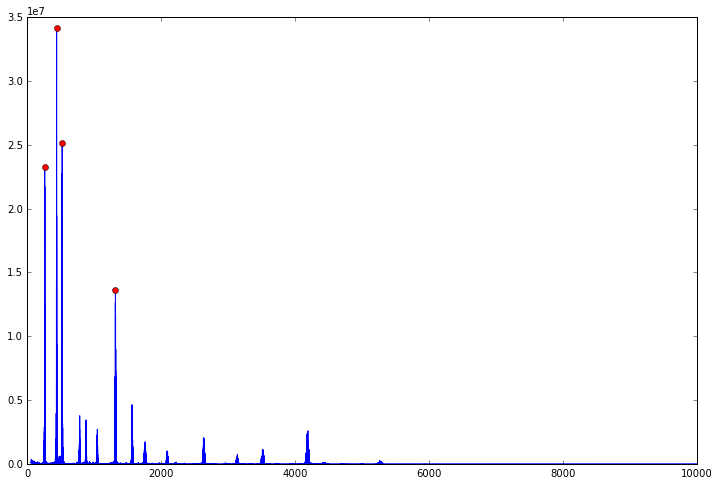

In [228]:
match_notes(find_peaks(*read_aiff('./sound_files/C4+A4_PopOrgan.aif'))[0])